In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import skimage as io
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening, selem

from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
import gc
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

print(os.listdir('/kaggle/input/flowers-recognition/flowers/flowers'))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['tulip', 'rose', 'dandelion', 'sunflower', 'daisy']


In [2]:
tulip = '/kaggle/input/flowers-recognition/flowers/flowers/tulip/*'
rose = '/kaggle/input/flowers-recognition/flowers/flowers/rose/*'
dandelion = '/kaggle/input/flowers-recognition/flowers/flowers/dandelion/*'
sunflower = '/kaggle/input/flowers-recognition/flowers/flowers/sunflower/*'
daisy = '/kaggle/input/flowers-recognition/flowers/flowers/daisy/*'

In [3]:
X = []
y =  []

In [4]:
def make_data(path, flower_type):
    paths = glob.glob(os.path.join(path))
    delete_rows = []
    for i, p in enumerate(paths):
        img = plt.imread(p)
        h,w,_ = img.shape
        
        if h>150 and w>150 and _==3: #  img.shape > (150,150,3):
            ## Custom code written here to avoid extra time to run
            img = img[int(h/2)-75 : int(h/2)+75,
                      int(w/2)-75 : int(w/2)+75, :]
            img = (img - np.min(img))/(np.max(img) - np.min(img))
            ## custom code for avoiding the extra execution time ends heres

            X.append(img)
            y.append(flower_type)
        else:
            delete_rows.append(i)
            continue
#         X.append(img)
#         y.append(flower_type)
        
flowers = ['tulip', 'rose', 'sunflower', 'daisy', 'dandelion']

In [5]:
make_data(tulip, 'tulip')
make_data(rose, 'rose')
make_data(sunflower, 'sunflower')
make_data(daisy, 'daisy')
make_data(dandelion, 'dandelion')

OSError: cannot identify image file '/kaggle/input/flowers-recognition/flowers/flowers/dandelion/run_me.py'

In [6]:
print('total no. of flowers {}'.format(len(X)))

total no. of flowers 3532


In [7]:
X[12].shape

(150, 150, 3)

# Randomly plotting Flower

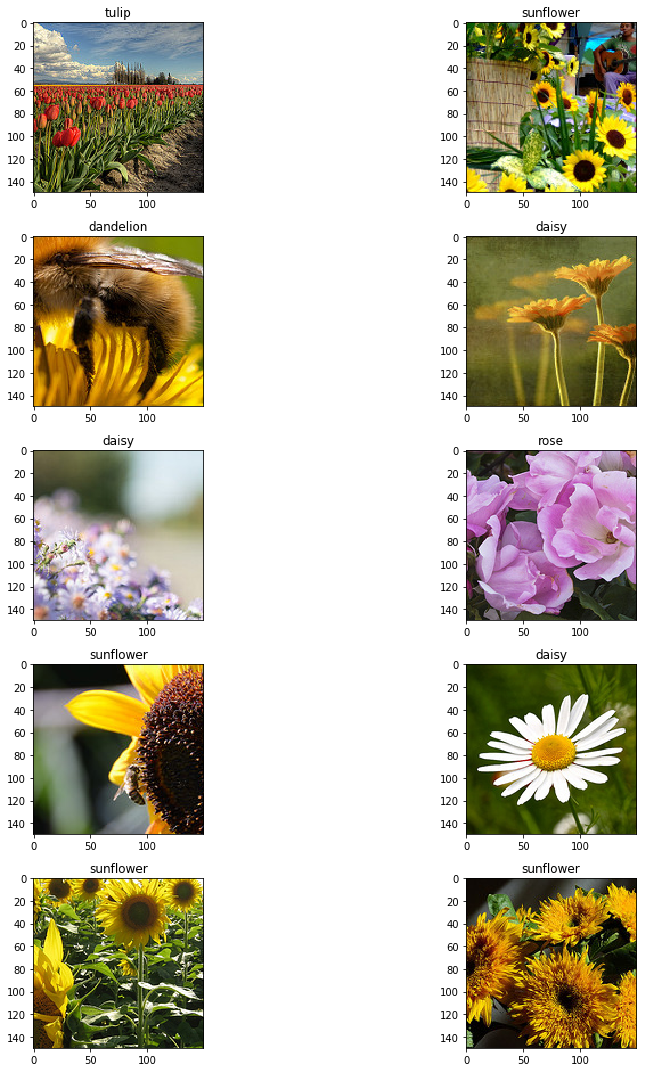

In [8]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        index = np.random.randint(len(y))
        ax[i, j].imshow(X[index])
        ax[i, j].set_title(y[index])
plt.tight_layout()
plt.show()

# Flower in RGB channels

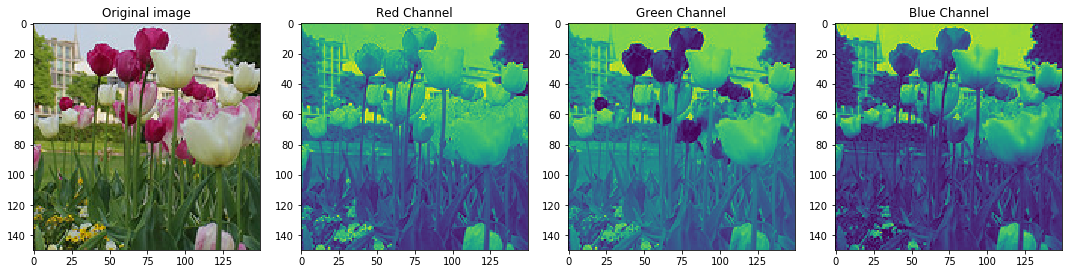

In [9]:
_, ax = plt.subplots(1,4)
_.set_size_inches(15,4)

ax[0].imshow(X[0])
ax[0].set_title('Original image')

ax[1].imshow(X[0][:,:, 0])
ax[1].set_title('Red Channel')

ax[2].imshow(X[0][:,:, 1])
ax[2].set_title('Green Channel')

ax[3].imshow(X[0][:,:, 2])
ax[3].set_title('Blue Channel')

plt.tight_layout()
plt.show()

# Morphological transformation

## Thresholding Considering threshold value to 150 
Pixels beyond 150 should me marked as 1 and others are marked as 0 

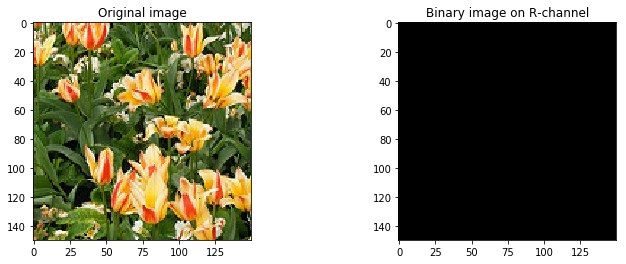

In [10]:
# Binary image R-channel
# 1929, 2263, 191, 1323, 3093, 342(final)
# index = np.random.randint(len(y))
index = 342

bin_img = X[index][:,:,0] > 150

_, ax = plt.subplots(1,2)
_.set_size_inches(12, 4)

ax[0].imshow(X[index], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(bin_img, cmap='gray')
ax[1].set_title('Binary image on R-channel')
plt.show()


# Applying Morphological transformation

In [11]:
# Creating disk
disk = selem.disk(3)
# Erosion
erosion = binary_erosion(bin_img, disk)

# Dilation
dilation = binary_dilation(bin_img, disk)

# Opening
opening = binary_opening(bin_img, disk)

# Closing
closing = binary_closing(bin_img, disk)

Text(0.5, 1.0, 'Closing image')

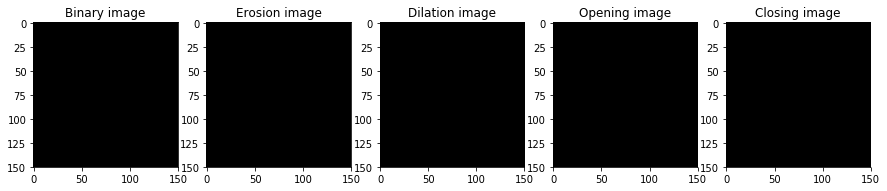

In [12]:
# Plotting binary and morphological images

_, ax = plt.subplots(1,5)

_.set_size_inches(15,4)

ax[0].imshow(bin_img, cmap='gray')
ax[0].set_title('Binary image')

ax[1].imshow(erosion, cmap='gray')
ax[1].set_title('Erosion image')

ax[2].imshow(dilation, cmap='gray')
ax[2].set_title('Dilation image')

ax[3].imshow(opening, cmap='gray')
ax[3].set_title('Opening image')

ax[4].imshow(closing, cmap='gray')
ax[4].set_title('Closing image')

# Image data Preprocessing 

In [13]:
X_final = np.empty((len(y), 150, 150, 3))
y_final = np.empty((len(y)))

## Preparing Train & test sets

In [14]:
# Making y_true to categorical with the help of LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
flowers = ['tulip', 'rose', 'sunflower', 'daisy', 'dandelion']
flowers = flowers[::-1]
y = keras.utils.to_categorical(LabelEncoder().fit_transform(y))

In [15]:
def list_to_4d_metrix(l):
    x_final = np.empty((len(l), 150, 150, 3))
    
    for i, img in enumerate(l):
        x_final[i, ] = img
    
    return x_final

In [16]:
X = list_to_4d_metrix(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [18]:
base_model = VGG16(include_top=False, input_shape=(150,150,3), weights='imagenet', pooling='avg')

58892288/58889256 [==============================] - 79s 1us/step


In [19]:
model = Sequential()

In [20]:
model.add(base_model)
# model.add(Dense(512))
# model.add(Activation('relu'))

# model.add(Dropout(0.5))

# model.add(Dense(5))
# model.add(Activation('softmax'))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [21]:
base_model.trainable=False
print(model.summary())
# model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [22]:
datagen = ImageDataGenerator(zca_whitening=False,
                             featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=False,
                             samplewise_std_normalization=False,
                             rotation_range=10,
                             horizontal_flip=True,
                             vertical_flip=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

In [23]:
data=datagen.flow(X_train, y_train, batch_size=32)

In [24]:
def fit(model):
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
    result = model.fit_generator(data,
                             epochs=32,
                             verbose=1,
                             steps_per_epoch=32,
                             validation_data=(X_test, y_test))
    return result

In [25]:
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 9s 266ms/step - loss: 1.5608 - accuracy: 0.2549 - val_loss: 1.5071 - val_accuracy: 0.3745
Epoch 2/32
32/32 [==============================] - 5s 156ms/step - loss: 1.4648 - accuracy: 0.3780 - val_loss: 1.4357 - val_accuracy: 0.3915
Epoch 3/32
32/32 [==============================] - 5s 165ms/step - loss: 1.4097 - accuracy: 0.4678 - val_loss: 1.3854 - val_accuracy: 0.4189
Epoch 4/32
32/32 [==============================] - 5s 158ms/step - loss: 1.3476 - accuracy: 0.5030 - val_loss: 1.3310 - val_accuracy: 0.5217
Epoch 5/32
32/32 [==============================] - 5s 169ms/step - loss: 1.3294 - accuracy: 0.5195 - val_loss: 1.2780 - val_accuracy: 0.5566
Epoch 6/32
32/32 [==============================] - 5s 162ms/step - loss: 1.2773 - accuracy: 0.5674 - val_loss: 1.2406 - val_accuracy: 0.5840
Epoch 7/32
32/32 [==============================] - 5s 158ms/step - loss: 1.2348 - accuracy: 0.5870 - val_loss: 1.2005 - val_accuracy: 0.5821
Epoch 

In [26]:
def accuracy_loss_plot(result):
    _, ax = plt.subplots(1,2)
    _.set_figwidth(15)
    _.set_figheight(5)
    

    ax[0].plot(result.history['loss'], label='Training Loss')
    ax[0].plot(result.history['val_loss'], label='Testing Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(result.history['accuracy'], label='Training Accuracy')
    ax[1].plot(result.history['val_accuracy'], label='Testing Accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    plt.tight_layout()
    plt.show()

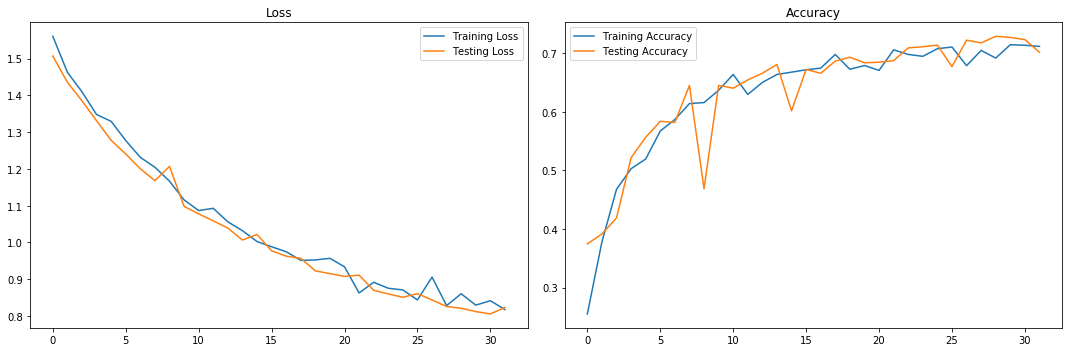

In [27]:
accuracy_loss_plot(result)

In [28]:
for i in range(len(base_model.layers[:18])):
    base_model.layers[i].trainable=False

for i in range(len(base_model.layers[18:])):
    base_model.layers[i].trainable=True

In [29]:
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 6s 196ms/step - loss: 0.8197 - accuracy: 0.7150 - val_loss: 0.7840 - val_accuracy: 0.7396
Epoch 2/32
32/32 [==============================] - 5s 159ms/step - loss: 0.7992 - accuracy: 0.7246 - val_loss: 0.7853 - val_accuracy: 0.7387
Epoch 3/32
32/32 [==============================] - 5s 161ms/step - loss: 0.8061 - accuracy: 0.7041 - val_loss: 0.7778 - val_accuracy: 0.7236
Epoch 4/32
32/32 [==============================] - 5s 161ms/step - loss: 0.7870 - accuracy: 0.7119 - val_loss: 0.7730 - val_accuracy: 0.7406
Epoch 5/32
32/32 [==============================] - 5s 159ms/step - loss: 0.8041 - accuracy: 0.7180 - val_loss: 0.7799 - val_accuracy: 0.7491
Epoch 6/32
32/32 [==============================] - 5s 158ms/step - loss: 0.7629 - accuracy: 0.7240 - val_loss: 0.7621 - val_accuracy: 0.7387
Epoch 7/32
32/32 [==============================] - 5s 161ms/step - loss: 0.7957 - accuracy: 0.7129 - val_loss: 0.7652 - val_accuracy: 0.7340
Epoch 

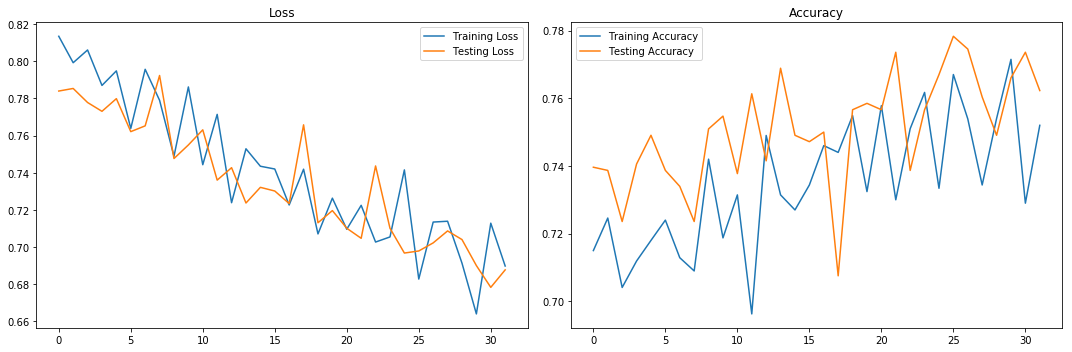

In [30]:
accuracy_loss_plot(result)

# Making last 5 layers of VGG16 trainable

In [31]:
for i in range(len(base_model.layers)):
    if i >= (len(base_model.layers)-5):
        base_model.layers[i].trainable = True
    else:
        base_model.layers[i].trainable = False

In [32]:
# Training the model
# result = fit(model)
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 6s 196ms/step - loss: 0.6432 - accuracy: 0.7540 - val_loss: 0.6769 - val_accuracy: 0.7764
Epoch 2/32
32/32 [==============================] - 5s 158ms/step - loss: 0.7420 - accuracy: 0.7354 - val_loss: 0.6920 - val_accuracy: 0.7557
Epoch 3/32
32/32 [==============================] - 5s 161ms/step - loss: 0.6909 - accuracy: 0.7549 - val_loss: 0.6773 - val_accuracy: 0.7764
Epoch 4/32
32/32 [==============================] - 5s 156ms/step - loss: 0.6927 - accuracy: 0.7560 - val_loss: 0.6864 - val_accuracy: 0.7632
Epoch 5/32
32/32 [==============================] - 5s 160ms/step - loss: 0.6786 - accuracy: 0.7500 - val_loss: 0.6911 - val_accuracy: 0.7613
Epoch 6/32
32/32 [==============================] - 5s 157ms/step - loss: 0.6876 - accuracy: 0.7530 - val_loss: 0.6833 - val_accuracy: 0.7575
Epoch 7/32
32/32 [==============================] - 5s 161ms/step - loss: 0.6518 - accuracy: 0.7578 - val_loss: 0.6682 - val_accuracy: 0.7755
Epoch 

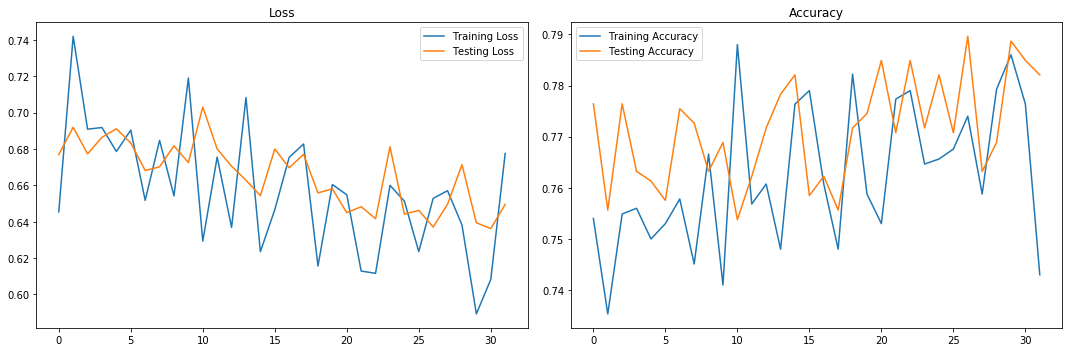

In [33]:
accuracy_loss_plot(result)

# Training full network

In [34]:
base_model.trainable=True

In [35]:
# Training the model
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 6s 200ms/step - loss: 1.4624 - accuracy: 0.4470 - val_loss: 2.0290 - val_accuracy: 0.4198
Epoch 2/32
32/32 [==============================] - 5s 160ms/step - loss: 0.7670 - accuracy: 0.7197 - val_loss: 0.5800 - val_accuracy: 0.7774
Epoch 3/32
32/32 [==============================] - 5s 165ms/step - loss: 0.6529 - accuracy: 0.7520 - val_loss: 0.7145 - val_accuracy: 0.7613
Epoch 4/32
32/32 [==============================] - 5s 166ms/step - loss: 0.5781 - accuracy: 0.7871 - val_loss: 0.8379 - val_accuracy: 0.6670
Epoch 5/32
32/32 [==============================] - 5s 168ms/step - loss: 0.5155 - accuracy: 0.8223 - val_loss: 0.4862 - val_accuracy: 0.8226
Epoch 6/32
32/32 [==============================] - 5s 162ms/step - loss: 0.4480 - accuracy: 0.8369 - val_loss: 0.5531 - val_accuracy: 0.7972
Epoch 7/32
32/32 [==============================] - 5s 162ms/step - loss: 0.4541 - accuracy: 0.8270 - val_loss: 0.5241 - val_accuracy: 0.8151
Epoch 

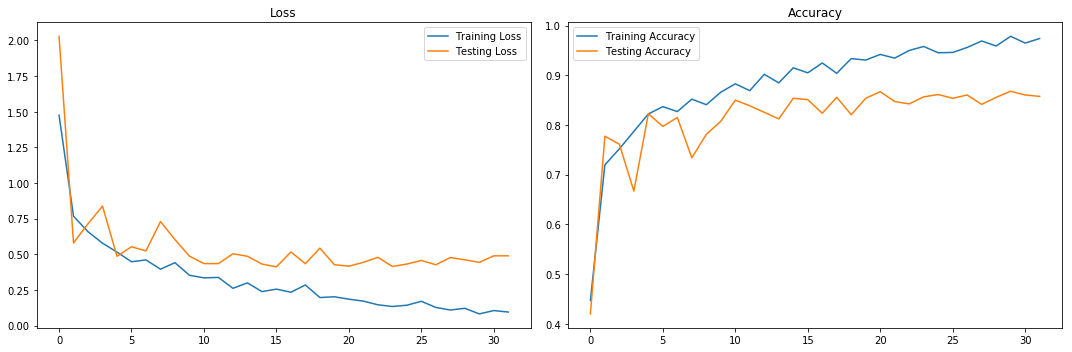

In [36]:
accuracy_loss_plot(result)

# ResNet50
### (Freezing all the layers except last)

In [37]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')

94658560/94653016 [==============================] - 39s 0us/step


In [38]:
model_resnet = Sequential()

In [39]:
model_resnet.add(resnet)

model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dense(5, activation='softmax'))

# model_resnet.add(resnet)

# model_resnet.add(Dense(256, activation='relu'))
# model_resnet.add(Dense(5, activation='softmax'))

In [40]:
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
_________________________________________________________________


In [41]:
model_resnet.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model_resnet.trainable=False

In [43]:
model_resnet.layers[-1].trainable=True

In [44]:
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 48,173,962
Trainable params: 24,060,421
Non-trainable params: 24,113,541
_________________________________________________________________


In [45]:
result = model_resnet.fit_generator(generator=data,
                           epochs=32,
                           steps_per_epoch=100,
                           verbose=1,
                           validation_data=(X_test, y_test))

Epoch 1/32
100/100 [==============================] - 50s 499ms/step - loss: 0.6654 - accuracy: 0.7563 - val_loss: 1.7861 - val_accuracy: 0.2094
Epoch 2/32
100/100 [==============================] - 24s 236ms/step - loss: 0.3041 - accuracy: 0.8942 - val_loss: 1.6870 - val_accuracy: 0.2094
Epoch 3/32
100/100 [==============================] - 24s 236ms/step - loss: 0.1731 - accuracy: 0.9454 - val_loss: 1.6486 - val_accuracy: 0.2009
Epoch 4/32
100/100 [==============================] - 24s 235ms/step - loss: 0.1300 - accuracy: 0.9588 - val_loss: 1.7926 - val_accuracy: 0.1255
Epoch 5/32
100/100 [==============================] - 23s 233ms/step - loss: 0.0905 - accuracy: 0.9743 - val_loss: 1.9574 - val_accuracy: 0.1113
Epoch 6/32
100/100 [==============================] - 23s 235ms/step - loss: 0.0617 - accuracy: 0.9856 - val_loss: 1.9208 - val_accuracy: 0.1123
Epoch 7/32
100/100 [==============================] - 23s 233ms/step - loss: 0.0630 - accuracy: 0.9841 - val_loss: 1.8146 - val_ac

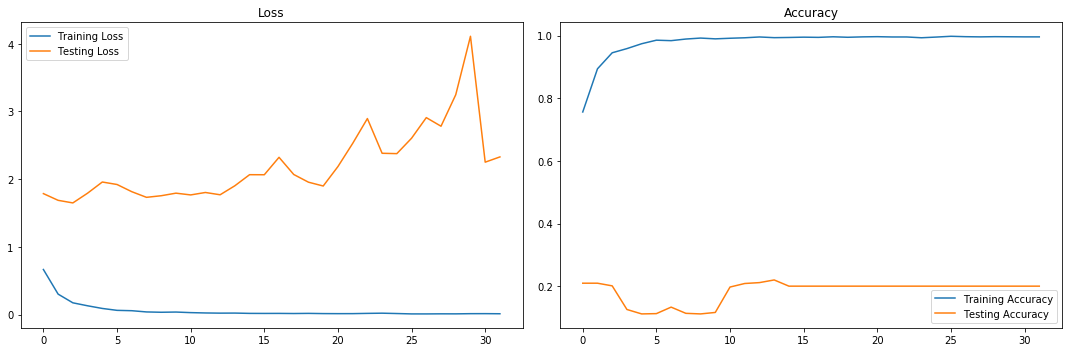

In [46]:
accuracy_loss_plot(result)

# ResNet50
### (Training on the full network)

In [47]:
resnet.trainable = True

In [48]:
# Compile
model_resnet.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# Fitting the model
result = model_resnet.fit_generator(generator=data,
                           epochs=32,
                           steps_per_epoch=100,
                           verbose=1,
                           validation_data=(X_test, y_test))

Epoch 1/32
100/100 [==============================] - 21s 214ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 2.3282 - val_accuracy: 0.2000
Epoch 2/32
100/100 [==============================] - 16s 156ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 2.3282 - val_accuracy: 0.2000
Epoch 3/32
100/100 [==============================] - 16s 157ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 2.3282 - val_accuracy: 0.2000
Epoch 4/32
100/100 [==============================] - 16s 159ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 2.3282 - val_accuracy: 0.2000
Epoch 5/32
100/100 [==============================] - 16s 157ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 2.3282 - val_accuracy: 0.2000
Epoch 6/32
100/100 [==============================] - 16s 160ms/step - loss: 0.0112 - accuracy: 0.9959 - val_loss: 2.3282 - val_accuracy: 0.2000
Epoch 7/32
100/100 [==============================] - 16s 156ms/step - loss: 0.0106 - accuracy: 0.9972 - val_loss: 2.3282 - val_ac

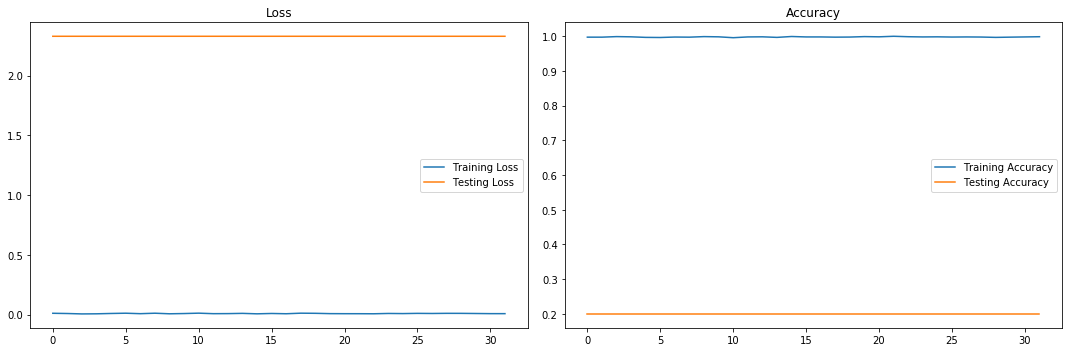

In [50]:
accuracy_loss_plot(result)